Note: the input signals are assumed to be preprocessed son only floats are included

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx


# SEL_SECTORS = ['Health Care', 'Consumer Staples', 'Energy', 'Financials']

SEL_SECTORS = ['Health Care', 'Consumer Staples', 'Energy', 'Financials',
               'Industrials', 'Information Technology']

PATH = './'


In [2]:
# Functions copied from motif_NTI repo (utils.py)
# Laplacian operator
def L_op(w):
    k = w.size
    N = int((1 + np.sqrt(1+8*k))/2)

    idx = np.triu_indices(N, k=1)
    A = np.zeros((N, N))
    A[idx] = w
    A = A + A.T
    return np.diag(np.sum(A, 0)) - A

def L_inv_op(L):
    N = L.shape[0]
    idx = np.triu_indices(N, k=1)
    return -L[idx]

def Lstar_op(Y):
    N = Y.shape[1]
    K = int(N*(N-1)/2)
    j = 0
    i = 1
    w = np.zeros(K)
    for k in range(K):
        w[k] = Y[i,i] + Y[j,j] - (Y[i,j] + Y[j,i])
        if (i == (N-1)):
            j += 1
            i = j + 1
        else:
            i += 1
    return w

# Functions copied from motif_NTI repo (baselines.py)
def step3(d, lambdas, rs):
    # Step 3: solved with cvx
    N = lambdas.shape[0]
    lambdas_hat = cp.Variable(N-rs['conn_comp'])  # Fisrt eigenvalues are 0

    contraints = [lambdas_hat >= rs['c1'], lambdas_hat <= rs['c2']]

    obj = cp.Minimize(cp.sum(-cp.log(lambdas_hat)) \
         + rs['beta']/2*cp.sum_squares(lambdas_hat-d))
    prob = cp.Problem(obj, contraints)

    try:      
        prob.solve()
    except cp.SolverError:
        print('WARNING: solver error')
        return lambdas

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print('WARNING: problem status', prob.status)
    else:
        lambdas = np.concatenate(([0]*rs['conn_comp'], lambdas_hat.value))

    return lambdas


def SGL(C, regs, max_iters=100, epsilon=1e-4):
    """
    Implementation of the spectral learning algorithm proposed in 'Structured Graph Learning 
    Via Laplacian Spectral Constraints', from Kumar S, Ying J, Cardoso J, Palomar D.
    """
    N = C.shape[0]
    K = C + regs['alpha']*(2*np.eye(N)-np.ones((N,N)))

    # Naive initialization
    L = np.linalg.pinv(C, rcond=1e-6, hermitian=True)
    L = np.where(L > 0, 0, L)
    L[np.eye(N, dtype=bool)] = -1*np.sum(L,1)

    w = L_inv_op(L)
    lambdas, V = np.linalg.eigh(L)
    prev_L = L
    prev_lam = lambdas

    for t in range(max_iters):
        # Step 1: closed form solution
        z = Lstar_op(V@np.diag(lambdas)@V.T-1/regs['beta']*K)
        gradient = Lstar_op(L_op(w))-z
        w = np.maximum(0, w-gradient/(2*N))
        L = L_op(w)
        if np.all((w == 0)):
            print('WARNING: L_hat is 0. Returning L from previous iteration')
            return prev_L, prev_lam

        # Step 2: eigendecomposition of step 1
        _, V = np.linalg.eigh(L)

        d = np.diag(V.T@L@V)[regs['conn_comp']:]
        lambdas = step3(d, lambdas, regs)

        L_conv = np.linalg.norm(L-prev_L, 'fro')/np.linalg.norm(prev_L, 'fro')
        prev_L = L
        prev_lam = lambdas

        if L_conv < epsilon:
            print('CONVERGENCE AT ITERATION:', t)
            break

    return L, lambdas

In [3]:
def smooth_GL(C, regs):
    N = C.shape[0]
    L_hat = cp.Variable((N, N),  PSD=True)  # Fisrt eigenvalues are 0
    contraints = [cp.sum(L_hat, 0) == 0, L_hat[~np.eye(N, dtype=bool) <= 0]]
    
    obj = cp.Minimize(cp.trace(C@L_hat) + regs['alpha']*cp.sum_squares(L_hat[~np.eye(N, dtype=bool)]) \
                      - regs['beta']*cp.sum(cp.log(cp.diag(L_hat))))
    
    prob = cp.Problem(obj, contraints)

    try:      
        prob.solve()
    except cp.SolverError:
        print('WARNING: solver error')

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print('WARNING: problem status', prob.status)

    return L_hat.value


def GMRF_GL(C, regs):
    N = C.shape[0]
    J = np.ones((N, N))/N
    L_hat = cp.Variable((N, N),  PSD=True)
    contraints = [cp.sum(L_hat, 0) == 0, L_hat[~np.eye(N, dtype=bool) <= 0]]
    
    obj = cp.Minimize(cp.trace(C@L_hat) - cp.log_det(L_hat + J)
    + regs['alpha']*cp.norm(L_hat[~np.eye(N, dtype=bool)], p=1))
    
    prob = cp.Problem(obj, contraints)

    try:      
        prob.solve()
    except cp.SolverError:
        print('WARNING: solver error')

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        print('WARNING: problem status', prob.status)

    return L_hat.value

In [4]:
def plot_graph(A):
    G = nx.from_numpy_array(A)
    N = A.shape[0]
    print('Nodes:', N)
    print('Degree:', np.sum(A)/N)
    print('Normalized number of edges: {:.3f}'.format(G.number_of_edges()*2/(N*(N-1))))
    print(np.linalg.norm(A,'fro'))

    plt.figure()
    nx.draw_spring(G)

    plt.figure()
    plt.imshow(A)
    plt.colorbar()
    print(A.max(), A[A != 0].min())

In [5]:
# def update_Thehta(L, J, Y, rho):
#     gammas, U = np.linalg.eigh(rho*(L + J) - Y)
#     N = gammas.shape[0]
#     Omega = U@np.diag(gammas+np.sqrt(gammas**2+4*rho*np.ones(N)))@U.T/(2*rho)
#     return Omega - J


# def update_w(S, Y, Theta, L, d, rho):
#     # Need to iterate
#     a_i = Lstar_op(S - Y - rho*(Theta - L))
#     #b_i dstar_op(y-rho*(d-d_op(w))) 

# def GL_financial(C, regs, max_iters=100, epsilon=1e-4):
#     """
#     Implementation of the spectral learning algorithm proposed in 'Structured Graph Learning 
#     Via Laplacian Spectral Constraints', from Kumar S, Ying J, Cardoso J, Palomar D.
#     """
#     N = C.shape[0]

#     J = np.ones((N))/N

#     # INIT PROPERLY
#     Y = np.zeros((N, N))
#     y = np.zeros(N)
#     Theta = np.zeros(1)
    

#     K = C + regs['alpha']*(2*np.eye(N)-np.ones((N,N)))

#     # Naive initialization
#     L = np.linalg.pinv(C, rcond=1e-6, hermitian=True)
#     L = np.where(L > 0, 0, L)
#     L[np.eye(N, dtype=bool)] = -1*np.sum(L,1)

#     w = L_inv_op(L)
#     lambdas, V = np.linalg.eigh(L)
#     prev_L = L
#     prev_lam = lambdas

#     for t in range(max_iters):
#         # Theta = update_Thehta()
#         # w = update_w()

#         # Step 1: closed form solution
#         z = Lstar_op(V@np.diag(lambdas)@V.T-1/regs['beta']*K)
#         gradient = Lstar_op(L_op(w))-z
#         w = np.maximum(0, w-gradient/(2*N))
#         L = L_op(w)
#         if np.all((w == 0)):
#             print('WARNING: L_hat is 0. Returning L from previous iteration')
#             return prev_L, prev_lam

#         # Step 2: eigendecomposition of step 1
#         _, V = np.linalg.eigh(L)

#         d = np.diag(V.T@L@V)[regs['conn_comp']:]
#         lambdas = step3(d, lambdas, regs)

#         L_conv = np.linalg.norm(L-prev_L, 'fro')/np.linalg.norm(prev_L, 'fro')
#         prev_L = L
#         prev_lam = lambdas

#         if L_conv < epsilon:
#             print('CONVERGENCE AT ITERATION:', t)
#             break

#     return L, lambdas

In [6]:
# Read data - Contain NaN values!
signals = pd.read_csv('dataX_2010_2015.csv', delimiter=';', dtype=float)
sector_data = pd.read_table('sp500_companies.csv', delimiter=';', encoding='cp1252')

# Select companies (nodes) and signals
companies = pd.DataFrame()
for sector in SEL_SECTORS:
    symbols = sector_data[sector_data['GICS Sector'] == sector]['Symbol']
    companies = pd.concat([companies, symbols])

print('Selected companies:', companies.shape[0])
sel_signals = signals.select_dtypes(float).filter(items=companies[0].values.tolist())
X_sel = sel_signals.to_numpy().T
X_sel[np.isnan(X_sel)] = 0
labels = sel_signals.columns

print('Shape of selected signals X:', X_sel.shape)
print('NOTE: companies may be lost if data is old and SP500 companies have changed')



Selected companies: 330
Shape of selected signals X: (189, 1510)
NOTE: companies may be lost if data is old and SP500 companies have changed


### Based on Spectral contraints

In [7]:
# Normalize X
X_norm = (X_sel - np.mean(X_sel, axis=0))/np.std(X_sel, axis=0)

# regs = {'alpha': .075, 'beta': 15, 'conn_comp': 1, 'c1': 0.01, 'c2': 30} # For 6 sectors
regs = {'alpha': .25, 'beta': 10, 'conn_comp': 1, 'c1': 0.01, 'c2': 15} # For 4 sectors

iters = 300
C = np.cov(X_norm)
print('Norm C: {:.3f} - Max(C): {:.3f} - Min(C): {:.3f}'.format(np.linalg.norm(C), C.max(), C.min()))

L, _ = SGL(C, regs, max_iters=iters, epsilon=1e-4)
A_spec = np.diag(np.diag(L)) - L

Norm C: 24.392 - Max(C): 4.128 - Min(C): -0.385


Nodes: 189
Degree: 1.0707124274647493
Normalized number of edges: 0.101
7.19728398182147
1.0144020821340318 0.0010083328670736054


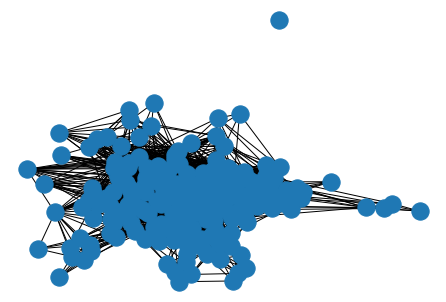

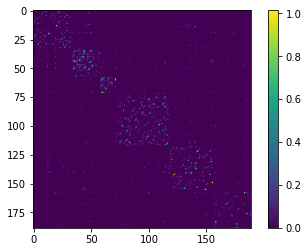

In [8]:
A_spec = np.diag(np.diag(L)) - L
A_spec[A_spec < .001] = 0
plot_graph(A_spec)

### Based on GMRF

In [9]:
# Normalize X
X_norm = (X_sel - np.mean(X_sel, axis=0))/np.std(X_sel, axis=0)

regs = {'alpha': 1.25}

C = np.cov(X_norm)
print('Norm C: {:.3f} - Max(C): {:.3f} - Min(C): {:.3f}'.format(np.linalg.norm(C), C.max(), C.min()))

L = GMRF_GL(C, regs)
A_GMRF = np.diag(np.diag(L)) - L



Norm C: 24.392 - Max(C): 4.128 - Min(C): -0.385


Nodes: 189
Degree: 0.27993779029957716
Normalized number of edges: 0.076
1.2194203341454521
0.11325679371939658 0.010008714775550773


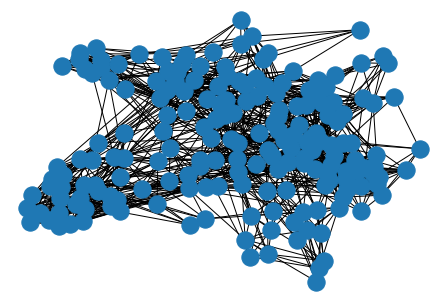

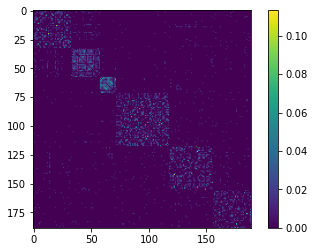

In [10]:
A_GMRF = np.diag(np.diag(L)) - L
A_GMRF[A_GMRF < .01] = 0
plot_graph(A_GMRF)


## Based on smoothness

In [21]:
# Normalize X
X_norm = X_sel/np.linalg.norm(X_sel, axis=0)

regs2 = {'alpha': .1, 'beta': .0005}

C = np.cov(X_norm)
print('Norm C: {:.3f} - Max(C): {:.3f} - Min(C): {:.3f}'.format(np.linalg.norm(C), C.max(), C.min()))

L = smooth_GL(C, regs2)
A_sm = np.diag(np.diag(L)) - L

Norm C: 0.292 - Max(C): 0.019 - Min(C): -0.000


Nodes: 189
Degree: 0.06308346323079594
Normalized number of edges: 0.086
0.23639263142658898
0.015347918029920783 0.0024002948700241307


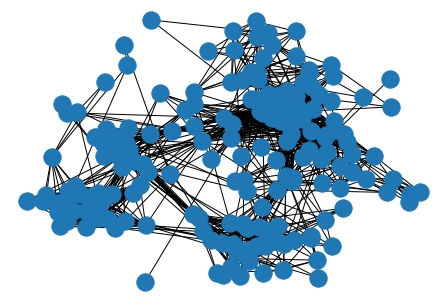

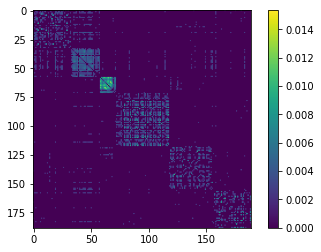

In [22]:
A_sm = np.diag(np.diag(L)) - L
# A_sm[A_sm < .0025] = 0  # with 4 sectors
A_sm[A_sm < .0024] = 0  # with 6 sectors
plot_graph(A_sm)

In [13]:
plt.show()

In [23]:
data = {
    'X': X_sel,
    'regs': regs,
    'iters': iters,
}

# data['A'] = A_spec
# file_name = '{}SP500_spec_{}sectors'.format(PATH, len(SEL_SECTORS))

# data['A'] = A_GMRF
# file_name = '{}SP500_GMRF_{}sectors'.format(PATH, len(SEL_SECTORS))

# data['A'] = A_sm
# file_name = '{}SP500_sm_{}sectors'.format(PATH, len(SEL_SECTORS))

# np.save(file_name, data)
# print('SAVED at:', file_name)

SAVED at: ./SP500_sm_6sectors
